#### Analyze ancestors

#### One-layer model

/tmp/ipykernel_4138495/1554793572.py:132: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_4138495/1554793572.py:132: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_4138495/1554793572.py:132: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


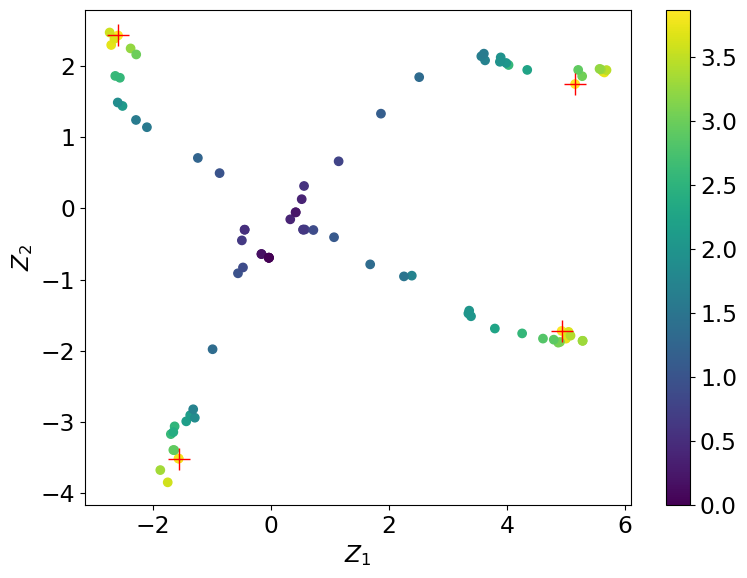

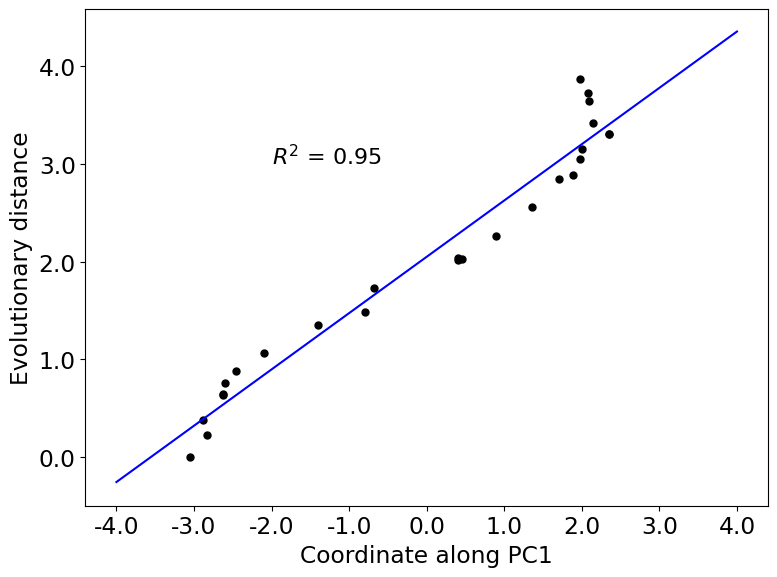

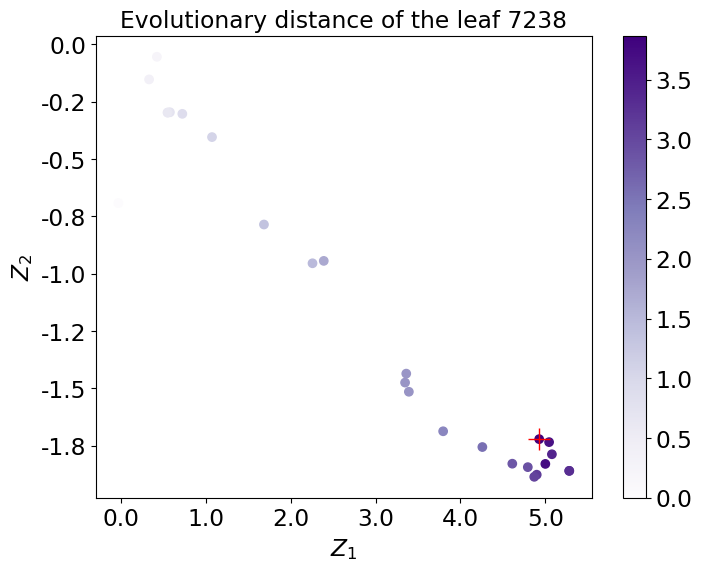

In [4]:
import pickle
from ete3 import Tree
from sys import exit
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn import linear_model
import scipy.stats as stats
from sklearn.decomposition import PCA

# Configure matplotlib settings for consistent font sizes
mpl.rc('font', size=14)
mpl.rc('axes', titlesize='large', labelsize='large')
mpl.rc('xtick', labelsize='large')
mpl.rc('ytick', labelsize='large')

## Load latent space representation from a saved .pkl file
with open("./output/onelayer_n100_weight0.01/latent_space.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
key = data['key']  # Keys corresponding to nodes in the latent space
mu = data['mu']    # Mean coordinates in the latent space
sigma = data['sigma']  # Standard deviations (not used further in this code)

## Load phylogenetic tree from Newick format file
t = Tree("./output/random_tree.newick", format=1)
num_leaf = len(t)  # Number of leaf nodes (tips of the tree)
t.name = str(num_leaf)  # Set the tree name to the number of leaf nodes

# Identify leaf and ancestral node indices based on node keys
leaf_idx = []
ancestral_idx = []
for i in range(len(key)):
    if int(key[i]) < num_leaf:
        leaf_idx.append(i)  # Append index if it's a leaf node
    else:
        ancestral_idx.append(i)  # Otherwise, it's an ancestral node

# Select four specific leaf nodes to analyze
leaf = ['9747', '1848', '3790', '7238']
colormap = ['Greys', 'Blues', 'Reds', 'Purples']  # Color maps for different leaves
anc_names = {}  # Dictionary to store ancestors of each leaf node

# Find ancestors for each leaf node and store their names
for n in leaf:
    anc_names[n] = []
    ancestors = (t & n).get_ancestors()  # Retrieve all ancestors of leaf node `n`
    for anc in ancestors:
        anc_names[n].append(anc.name)  # Store ancestor names for later use

# Plot latent space representation for selected leaf nodes and their ancestors
fig = plt.figure(0, figsize=(8, 6))
fig.clf()
for k in range(len(leaf)):
    leaf_name = leaf[k]
    idx = key.index(leaf_name)  # Find index of leaf in `key`
    # Create a DataFrame to store mu coordinates and evolutionary depth for the leaf and its ancestors
    data = pd.DataFrame(index=[leaf_name] + anc_names[leaf_name], columns=("mu1", 'mu2', 'depth'))
    data.loc[leaf_name, :] = (mu[idx, 0], mu[idx, 1], t.get_distance(t & leaf_name))
    num_anc = len(anc_names[leaf_name])
    for i in range(num_anc):
        n = anc_names[leaf_name][i]
        idx = key.index(n)
        data.loc[n, :] = (mu[idx, 0], mu[idx, 1], t.get_distance(t & n))

    # Scatter plot of mu coordinates for the leaf and its ancestors
    plt.scatter(data.loc[:, 'mu1'], data.loc[:, 'mu2'], c=data.loc[:, 'depth'], cmap=plt.get_cmap('viridis'))
    plt.plot(data.loc[leaf_name, 'mu1'], data.loc[leaf_name, 'mu2'], '+r', markersize=16)

# Configure labels, colorbar, and save plot as a 300 dpi PNG
plt.xlabel("$Z_1$")
plt.ylabel("$Z_2$")
plt.colorbar()
plt.tight_layout()
plt.savefig("./output/onelayer_n100_weight0.01/leaf_ancestry_latent_space.png", dpi=300, format='png')

# Initialize lists for Pearson correlation and set up PCA and linear regression models
PCC = []
pca = PCA(n_components=2)
reg = linear_model.LinearRegression()

# Loop over each leaf to perform PCA and analyze the evolutionary distance relationship
for k in range(len(leaf)):
    leaf_name = leaf[k]
    idx = key.index(leaf_name)
    # Create DataFrame for coordinates and depth of each leaf and its ancestors
    data = pd.DataFrame(index=[leaf_name] + anc_names[leaf_name], columns=("mu1", 'mu2', 'depth'))
    data.loc[leaf_name, :] = (mu[idx, 0], mu[idx, 1], t.get_distance(t & leaf_name))
    num_anc = len(anc_names[leaf_name])
    for i in range(num_anc):
        n = anc_names[leaf_name][i]
        idx = key.index(n)
        data.loc[n, :] = (mu[idx, 0], mu[idx, 1], t.get_distance(t & n))

    # Convert DataFrame to numpy array and apply PCA on the mu coordinates
    data = np.array(data).astype(np.float64)
    pca.fit(data[:, 0:2])
    pca_coor = pca.transform(data[:, 0:2])

    # Ensure consistent direction for the first principal component
    if np.sum(pca.components_[0, :] * data[0, 0:2]) < 0:
        main_coor = -pca_coor[:, 0]
    else:
        main_coor = pca_coor[:, 0]

    # Calculate Pearson correlation between main coordinate and depth
    PCC.append(stats.pearsonr(main_coor, data[:, 2])[0])

    # Fit linear regression on main coordinate vs. depth
    res = reg.fit(main_coor.reshape((-1, 1)), data[:, -1])
    yhat = res.predict(main_coor.reshape((-1, 1)))

    # Calculate R-squared for the regression model
    SS_res = np.sum((data[:, -1] - yhat) ** 2)
    SS_tot = np.sum((data[:, -1] - np.mean(data[:, -1])) ** 2)
    r2 = 1 - SS_res / SS_tot

    # Generate regression line for plotting
    reg_x = np.linspace(-4, 4, 30)
    reg_y = reg.intercept_ + reg.coef_[0] * reg_x
    fig = plt.figure(1, figsize=(8, 6))
    fig.clf()
    plt.plot(main_coor, data[:, -1], 'k.', markersize=10)  # Plot main coordinates vs. depth
    plt.plot(reg_x, reg_y, 'b')  # Plot regression line
    plt.text(-2, 3, r"$R^2$ = {:.2f}".format(r2), size=16)
    plt.ylim(-0.5, )
    plt.xlabel("Coordinate along PC1")
    plt.ylabel("Evolutionary distance")
    plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    plt.tight_layout()
    # Save regression plot as PNG with 300 dpi
    plt.savefig("./output/onelayer_n100_weight0.01/scatter_main_coor_dist_{}.png".format(leaf_name), dpi=300, format='png')

# Generate individual latent space plots for each leaf with color-coded depth
for k in range(len(leaf)):
    leaf_name = leaf[k]
    idx = key.index(leaf_name)
    # Create DataFrame for each leaf and its ancestors
    data = pd.DataFrame(index=[leaf_name] + anc_names[leaf_name], columns=("mu1", 'mu2', 'depth'))
    data.loc[leaf_name, :] = (mu[idx, 0], mu[idx, 1], t.get_distance(t & leaf_name))
    num_anc = len(anc_names[leaf_name])
    for i in range(num_anc):
        n = anc_names[leaf_name][i]
        idx = key.index(n)
        data.loc[n, :] = (mu[idx, 0], mu[idx, 1], t.get_distance(t & n))

    # Plot the mu coordinates and color by depth using individual colormaps for each leaf
    fig = plt.figure(2, figsize=(8, 6))
    fig.clf()
    plt.scatter(data.loc[:, 'mu1'], data.loc[:, 'mu2'], c=data.loc[:, 'depth'], cmap=plt.get_cmap(colormap[k]))
    plt.plot(data.loc[leaf_name, 'mu1'], data.loc[leaf_name, 'mu2'], '+r', markersize=16)
    plt.title("Evolutionary distance of the leaf {}".format(leaf_name))
    plt.xlabel("$Z_1$")
    plt.ylabel("$Z_2$")
    plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    plt.colorbar()
    # Save each individual plot as a 300 dpi PNG
    plt.savefig("./output/onelayer_n100_weight0.01/leaf_{}.png".format(leaf_name), dpi=300, format='png')

#### Two-layer model

/tmp/ipykernel_4138495/2073376570.py:133: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_4138495/2073376570.py:133: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_4138495/2073376570.py:133: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


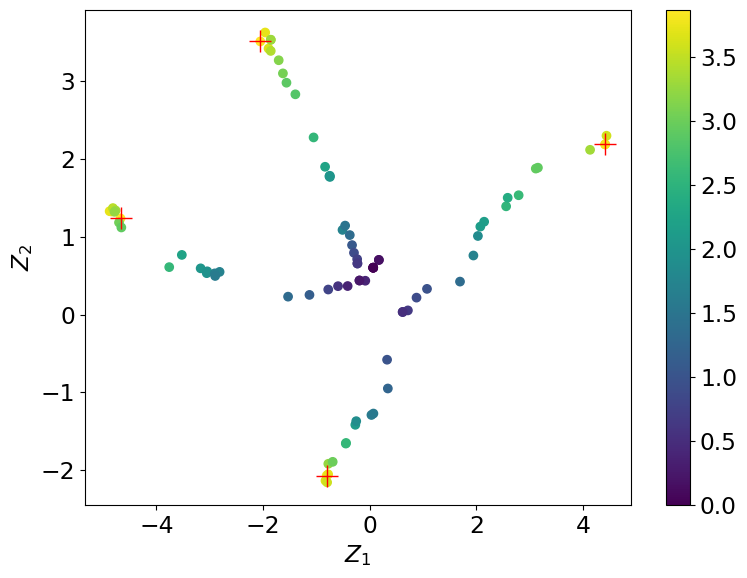

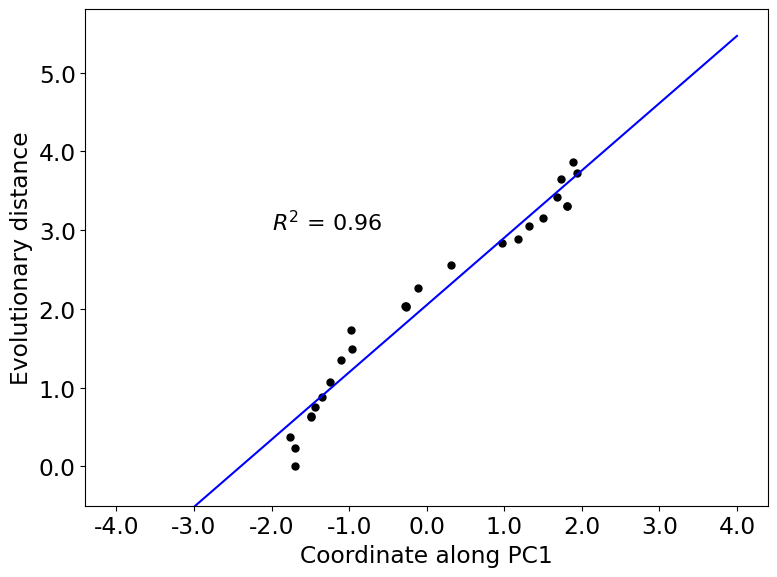

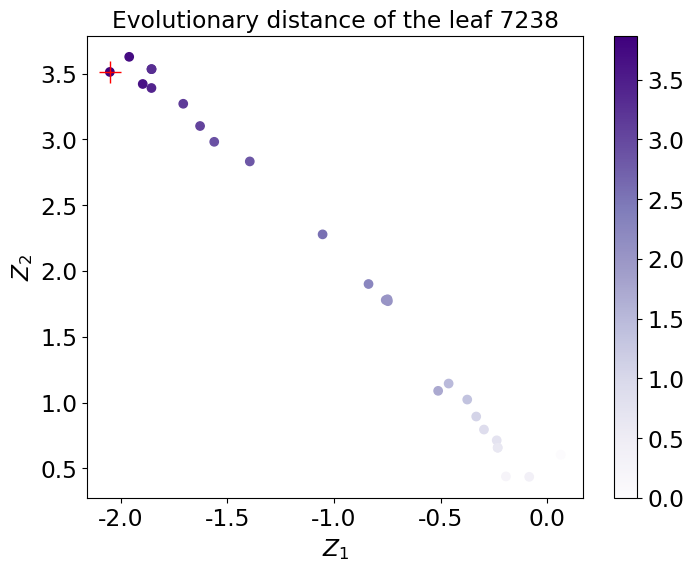

In [5]:
import pickle
from ete3 import Tree
from sys import exit
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn import linear_model
import scipy.stats as stats
from sklearn.decomposition import PCA


# Configure matplotlib settings for consistent font sizes
mpl.rc('font', size=14)
mpl.rc('axes', titlesize='large', labelsize='large')
mpl.rc('xtick', labelsize='large')
mpl.rc('ytick', labelsize='large')

## Load latent space representation from a saved .pkl file
with open("./output/twolayer_n100_500_weight0.01/latent_space.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
key = data['key']  # Keys corresponding to nodes in the latent space
mu = data['mu']    # Mean coordinates in the latent space
sigma = data['sigma']  # Standard deviations (not used further in this code)

## Load phylogenetic tree from Newick format file
t = Tree("./output/random_tree.newick", format=1)
num_leaf = len(t)  # Number of leaf nodes (tips of the tree)
t.name = str(num_leaf)  # Set the tree name to the number of leaf nodes

# Identify leaf and ancestral node indices based on node keys
leaf_idx = []
ancestral_idx = []
for i in range(len(key)):
    if int(key[i]) < num_leaf:
        leaf_idx.append(i)  # Append index if it's a leaf node
    else:
        ancestral_idx.append(i)  # Otherwise, it's an ancestral node

# Select four specific leaf nodes to analyze
leaf = ['9747', '1848', '3790', '7238']
colormap = ['Greys', 'Blues', 'Reds', 'Purples']  # Color maps for different leaves
anc_names = {}  # Dictionary to store ancestors of each leaf node

# Find ancestors for each leaf node and store their names
for n in leaf:
    anc_names[n] = []
    ancestors = (t & n).get_ancestors()  # Retrieve all ancestors of leaf node `n`
    for anc in ancestors:
        anc_names[n].append(anc.name)  # Store ancestor names for later use

# Plot latent space representation for selected leaf nodes and their ancestors
fig = plt.figure(0, figsize=(8, 6))
fig.clf()
for k in range(len(leaf)):
    leaf_name = leaf[k]
    idx = key.index(leaf_name)  # Find index of leaf in `key`
    # Create a DataFrame to store mu coordinates and evolutionary depth for the leaf and its ancestors
    data = pd.DataFrame(index=[leaf_name] + anc_names[leaf_name], columns=("mu1", 'mu2', 'depth'))
    data.loc[leaf_name, :] = (mu[idx, 0], mu[idx, 1], t.get_distance(t & leaf_name))
    num_anc = len(anc_names[leaf_name])
    for i in range(num_anc):
        n = anc_names[leaf_name][i]
        idx = key.index(n)
        data.loc[n, :] = (mu[idx, 0], mu[idx, 1], t.get_distance(t & n))

    # Scatter plot of mu coordinates for the leaf and its ancestors
    plt.scatter(data.loc[:, 'mu1'], data.loc[:, 'mu2'], c=data.loc[:, 'depth'], cmap=plt.get_cmap('viridis'))
    plt.plot(data.loc[leaf_name, 'mu1'], data.loc[leaf_name, 'mu2'], '+r', markersize=16)

# Configure labels, colorbar, and save plot as a 300 dpi PNG
plt.xlabel("$Z_1$")
plt.ylabel("$Z_2$")
plt.colorbar()
plt.tight_layout()
plt.savefig("./output/twolayer_n100_500_weight0.01/leaf_ancestry_latent_space.png", dpi=300, format='png')

# Initialize lists for Pearson correlation and set up PCA and linear regression models
PCC = []
pca = PCA(n_components=2)
reg = linear_model.LinearRegression()

# Loop over each leaf to perform PCA and analyze the evolutionary distance relationship
for k in range(len(leaf)):
    leaf_name = leaf[k]
    idx = key.index(leaf_name)
    # Create DataFrame for coordinates and depth of each leaf and its ancestors
    data = pd.DataFrame(index=[leaf_name] + anc_names[leaf_name], columns=("mu1", 'mu2', 'depth'))
    data.loc[leaf_name, :] = (mu[idx, 0], mu[idx, 1], t.get_distance(t & leaf_name))
    num_anc = len(anc_names[leaf_name])
    for i in range(num_anc):
        n = anc_names[leaf_name][i]
        idx = key.index(n)
        data.loc[n, :] = (mu[idx, 0], mu[idx, 1], t.get_distance(t & n))

    # Convert DataFrame to numpy array and apply PCA on the mu coordinates
    data = np.array(data).astype(np.float64)
    pca.fit(data[:, 0:2])
    pca_coor = pca.transform(data[:, 0:2])

    # Ensure consistent direction for the first principal component
    if np.sum(pca.components_[0, :] * data[0, 0:2]) < 0:
        main_coor = -pca_coor[:, 0]
    else:
        main_coor = pca_coor[:, 0]

    # Calculate Pearson correlation between main coordinate and depth
    PCC.append(stats.pearsonr(main_coor, data[:, 2])[0])

    # Fit linear regression on main coordinate vs. depth
    res = reg.fit(main_coor.reshape((-1, 1)), data[:, -1])
    yhat = res.predict(main_coor.reshape((-1, 1)))

    # Calculate R-squared for the regression model
    SS_res = np.sum((data[:, -1] - yhat) ** 2)
    SS_tot = np.sum((data[:, -1] - np.mean(data[:, -1])) ** 2)
    r2 = 1 - SS_res / SS_tot

    # Generate regression line for plotting
    reg_x = np.linspace(-4, 4, 30)
    reg_y = reg.intercept_ + reg.coef_[0] * reg_x
    fig = plt.figure(1, figsize=(8, 6))
    fig.clf()
    plt.plot(main_coor, data[:, -1], 'k.', markersize=10)  # Plot main coordinates vs. depth
    plt.plot(reg_x, reg_y, 'b')  # Plot regression line
    plt.text(-2, 3, r"$R^2$ = {:.2f}".format(r2), size=16)
    plt.ylim(-0.5, )
    plt.xlabel("Coordinate along PC1")
    plt.ylabel("Evolutionary distance")
    plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    plt.tight_layout()
    # Save regression plot as PNG with 300 dpi
    plt.savefig("./output/twolayer_n100_500_weight0.01/scatter_main_coor_dist_{}.png".format(leaf_name), dpi=300, format='png')

# Generate individual latent space plots for each leaf with color-coded depth
for k in range(len(leaf)):
    leaf_name = leaf[k]
    idx = key.index(leaf_name)
    # Create DataFrame for each leaf and its ancestors
    data = pd.DataFrame(index=[leaf_name] + anc_names[leaf_name], columns=("mu1", 'mu2', 'depth'))
    data.loc[leaf_name, :] = (mu[idx, 0], mu[idx, 1], t.get_distance(t & leaf_name))
    num_anc = len(anc_names[leaf_name])
    for i in range(num_anc):
        n = anc_names[leaf_name][i]
        idx = key.index(n)
        data.loc[n, :] = (mu[idx, 0], mu[idx, 1], t.get_distance(t & n))

    # Plot the mu coordinates and color by depth using individual colormaps for each leaf
    fig = plt.figure(2, figsize=(8, 6))
    fig.clf()
    plt.scatter(data.loc[:, 'mu1'], data.loc[:, 'mu2'], c=data.loc[:, 'depth'], cmap=plt.get_cmap(colormap[k]))
    plt.plot(data.loc[leaf_name, 'mu1'], data.loc[leaf_name, 'mu2'], '+r', markersize=16)
    plt.title("Evolutionary distance of the leaf {}".format(leaf_name))
    plt.xlabel("$Z_1$")
    plt.ylabel("$Z_2$")
    plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    plt.colorbar()
    # Save each individual plot as a 300 dpi PNG
    plt.savefig("./output/twolayer_n100_500_weight0.01/leaf_{}.png".format(leaf_name), dpi=300, format='png')
